##2. Linear SVM with Hard Margin

In [3]:
from pylab import *
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import *
from cvxopt import matrix
from cvxopt import solvers
#from __future__ import division
import random
t=np.seterr(divide='ignore', invalid='ignore')
solvers.options['show_progress'] = False

###Generate Synthetic Linear and Non-Linear Dataset

In [4]:
def normalize(data):
    
    [nrows, ncols] = data.shape
    col_mean = np.zeros(ncols-1).reshape(ncols-1, 1)
    col_sd = np.zeros(ncols-1).reshape(ncols-1, 1)
    normalized_data = data.astype(float64)
    
    for i in range(ncols-1):
        col_mean[i] = np.mean(data[:,i])
        col_sd = np.std(data[:,i])
        normalized_data[:,i] = [(data[:,i][j] - col_mean[i])/col_sd for j in range(nrows)]
    
    #print "Normal", normalized_data
    return normalized_data

###Generating for the Classification

In [62]:
def getData(data, size):
    
    if data=='Linear':
        mean1 = np.array([0, 1])
        mean2 = np.array([1, 0])
        cov = np.array([[0.4, 0.3], [0.3, 0.4]])
        target = np.array([1, -1])
        sample = int(size/2)
        
        x1 = np.random.multivariate_normal(mean1, cov, sample)
        #print "x1", x1.shape
        y1 = np.ones(len(x1)) * target[0]
        y1 = y1.reshape(sample,1)
        #print "y1", y1.shape
        x2 = np.random.multivariate_normal(mean2, cov, sample)
        y2 = np.ones(len(x2)) * target[1]
        y2 = y2.reshape(sample,1)
        
        c1 = np.hstack((x1,y1))
        c2 = np.hstack((x2,y2))
        dataset = np.vstack((c1,c2))
        
    elif data == 'Non-Separable':
        mean = np.array([0, 1])
        cov = np.array([[1.4, 1.3], [1.3, 1.4]])
        target = np.array([1, -1])
        sample = int(size/2)
        
        x1 = np.random.multivariate_normal(mean, cov, sample)
        #print "x1", x1.shape
        y1 = np.ones(len(x1)) * target[0]
        y1 = y1.reshape(sample,1)
        #print "y1", y1.shape
        x2 = np.random.multivariate_normal(mean, cov, sample)
        y2 = np.ones(len(x2)) * target[1]
        y2 = y2.reshape(sample,1)
        
        c1 = np.hstack((x1,y1))
        c2 = np.hstack((x2,y2))
        dataset = np.vstack((c1,c2))
        
    elif data == 'Iris':
        from sklearn import datasets
        data = datasets.load_iris()
        #data = datasets.load_diabetes()
        X = data['data']
        Y = data['target']
        Y = Y.reshape(len(data['target']), 1)
        dataset = np.hstack((X, Y))
        
        idx_k=[]
        (m, n) = dataset.shape
        class_k = np.unique(dataset[:,n-1])
        k = len(class_k)
        for i in range(2):
            idx_k.append(filter((lambda x : dataset[:,n-1][x] == class_k[i]), range(m)))
        idx_k = np.concatenate((idx_k[0], idx_k[1]), axis=0)
        dataset = dataset[idx_k]
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        #print "X", X.shape
        #print "Y", Y.shape
        class_k = np.unique(Y)
        for i in range(len(idx_k)):
            if Y[i] == class_k[0]:
                Y[i] = -1
            else:
                Y[i] = 1
        Y= Y.reshape(len(idx_k),1)
        dataset = np.hstack((X,Y))
        dataset = normalize(dataset)
        
    elif data == 'Breast-Cancer':
        with open('breast-cancer-wisconsin.data','r') as f:
            records=[]
            for line in f:
                records.append(line.split(','))
        records = records[2:]
        dataset = np.array(records).astype(np.int)
        
        class_k = np.unique(dataset[:,-1])
        for i in range(len(dataset)):
            if dataset[i,-1] == class_k[0]:
                dataset[i,-1] = -1
            else:
                dataset[i,-1] = 1
        dataset = normalize(dataset)
        
    elif data == "Bank":
        with open('data_banknote_authentication.txt') as f:
            records=[]
            for line in f:
                records.append(line.split(','))
        records = records[2:]
        dataset = np.array(records).astype(float)
        class_k = np.unique(dataset[:,-1])
        for i in range(len(dataset)):
            if dataset[i,-1] == class_k[0]:
                dataset[i,-1] = -1
            else:
                dataset[i,-1] = 1
        dataset = normalize(dataset)     
    #return normalize(dataset)
    return dataset

###Calculate the Lagrange Multipliers

In [6]:
def getLagrangeMultipliers(x, y, C):
    (m, n) = x.shape
    
    p = (np.dot(y, y.T) * np.dot(x, x.T))
    P = matrix(p, (m, m))
    #print "P", P
        
    q = np.ones(m) * -1
    Q = matrix(q, (m,1), tc='d')
    #print "Q", Q.size, Q
        
    A = matrix(y.T, (1,m))
    #print "A", A
        
    b = matrix(0.0)
    #print "b", b
        
    g1 = np.diag(np.ones(m) * -1)
    g2 = np.identity(m)
        
    #print "g1,g2", g1.shape, g2.shape
    g = np.vstack((g1,g2))
    #print "g", g.shape, g
    G = matrix(g, (2*m, m)) #softmargin
    #print "G", G
        
    h1 = np.zeros(m).reshape(m,1)
    h2 = np.ones(m).reshape(m,1)
    h2 = h2 * C
    #print "h1,h2", h1.shape, h2.shape
    H = np.vstack((h1,h2))
    #print "h", H.shape
    h = matrix(H, (2*m,1)) #soft margin
    
    #print "H", h
        
    sol = solvers.qp(P,Q, G, h, A, b)
    
    return sol['x']

In [7]:
def getSVIdx(alpha, threshold):
    (m, n) = alpha.shape
    svIdx = []
    
    for i in range(m):
        if alpha[i] > threshold:
            svIdx.append(i)

    return svIdx

In [8]:
def getConfusionMatrix(actual, prediction, labels):
    #print "incoming", actual, prediction
    k = len(labels)
    m = len(actual)
    cm = np.zeros((k, k))
    for i in range(k):
        actual_i = filter(lambda x: actual[x] == labels[i], range(m))
        for j in range(k):
            predicted_j = filter(lambda x: prediction[x] == labels[j], range(m))
            cm[i,j] = len(np.intersect1d(actual_i, predicted_j))
    #print "outgoing", cm
    return cm

In [9]:
def getAccuracy(matrix):
    return np.trace(matrix)/np.sum(matrix)

def getPrecision(matrix):
    k = len(matrix)
    precision = np.zeros(k)
    for i in range(k):
        actual_positives = np.sum(matrix[i])
        precision[i] = matrix[i,i]/actual_positives
    return precision

def getRecall(matrix):
    k = len(matrix)
    recall = np.zeros(k)
    for i in range(k):
        predicted_positives = np.sum(matrix[:,i])
        recall[i] = matrix[i,i]/predicted_positives
    return recall

def getFMeasure(precision, recall):
    k = len(precision)
    fm = np.zeros(k)
    for i in range(k):
        fm[i] = 2* precision[i]*recall[i]/(precision[i]+recall[i])
    return fm

###Sckit SVC Library

In [10]:
def validation(train_dataset, test_dataset, labels, params):
    from sklearn import svm
    C = params['C']  # SVM regularization parameter
    X = train_dataset[:,:-1]
    y = train_dataset[:,-1]
    
    svc = svm.SVC(kernel='linear', C=C).fit(X, y)
    #rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
    #poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
    #lin_svc = svm.LinearSVC(C=C).fit(X, y)
    X_test = test_dataset[:,:-1]
    y_test = test_dataset[:,-1]
    y_predict = svc.predict(X_test)        
    return getConfusionMatrix(y_test, y_predict, labels)

###Support Vector Machine

In [18]:
class SVM:
    def __init__(self, size):

        self.W = np.zeros((size))
        self.W0 = 0
        
    def train(self, data, params):
        C = params['C']
        alpha_threshold = params['alpha_threshold']
        #print "Training", data
        (m,n) = data.shape
        x_train = data[:,:n-1]
        y_train = data[:,-1]
        
        #1. Solve for Dual
        alpha = getLagrangeMultipliers(x_train, y_train, C)
        alpha = np.array(alpha)
        #alpha_threshold = np.median(alpha) * 0.75
        #print "Median", alpha_threshold
        #print "Alpha",  alpha.shape, alpha
        
        #2. Identify Support Vectors
        svIdx = getSVIdx(alpha, alpha_threshold)
        svX = x_train[svIdx]
        svY = y_train[svIdx]
        svAlpha = alpha[svIdx]
        
        svm = len(svIdx)
        print "Support Vectors", len(svIdx), np.min(svAlpha), np.max(svAlpha)
        fileName = params['dataset']
        if fileName == 'Linear' or fileName == 'Non-Separable':
            plt.figure()
            for i in range(m):
                if i in svIdx:
                    plt.scatter(x_train[i,0], x_train[i,1], marker='o', color='r')
                else:
                    if y_train[i] == 1:
                        plt.scatter(x_train[i,0], x_train[i,1], marker='<', color='b')
                    else:
                        plt.scatter(x_train[i,0], x_train[i,1], marker='>', color='g')
        
        #3. Compute W
        sum = 0
        for i in range(svm):
            sum += svAlpha[i] * svX[i] * svY[i]
        self.W = sum
        #print "W", self.W
        
        #4. Compute W0
        sum = 0
        for i in range(svm):
            sum += svY[i] - np.dot(self.W.T, svX[i])
        self.W0 = sum/svm
        #print "W0", self.W0
    
    def test(self, data, labels):
        (m,n) = data.shape
        x_test = data[:,:n-1]
        y_test = data[:,-1]
        y_hat = np.dot(x_test, self.W.T) + self.W0
        y_predict = [labels[0] if y_hat[i] < 0 else labels[1] for i in range(m)]
        #for i in range(m):
            #print "Y=", y_test[i], "Y_est=", y_predict[i]
        return getConfusionMatrix(y_test, y_predict, labels)

###Main function triggering the experiment

x1 (50L, 2L)
y1 (50L, 1L)
(100L, 3L)
[-1.  1.]
Support Vectors 7 0.0226647812283 0.09999999962
Support Vectors 6 0.0579622736758 0.0999999998961
Support Vectors 7 0.0226648347766 0.0999999997102
Support Vectors 7 0.0226648055129 0.0999999997333
Support Vectors 5 0.0208293426892 0.0999999998839
Support Vectors 5 0.01955934324 0.0999999999742
Support Vectors 7 0.0226647549808 0.0999999996424
Support Vectors 7 0.0395441231015 0.0999999993999
Support Vectors 7 0.0226648611702 0.0999999996954
Support Vectors 7 0.0226647968909 0.0999999995172
Confusion Matrix
[[ 23.  27.]
 [ 26.  24.]]
Confusion Matrix(SciKit Library)
[[  0.  50.]
 [ 47.   3.]]
Accuracy	:	0.47
Precision	:	0.46
Recall		:	0.469387755102
F-Measure	:	0.464646464646


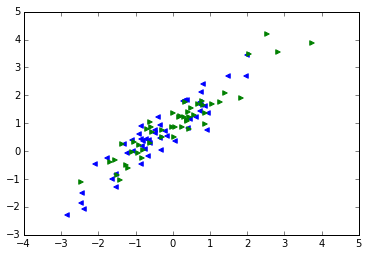

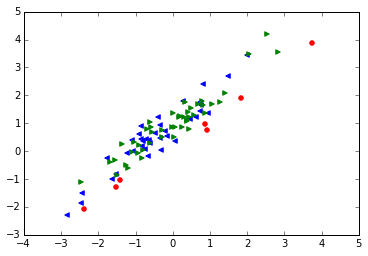

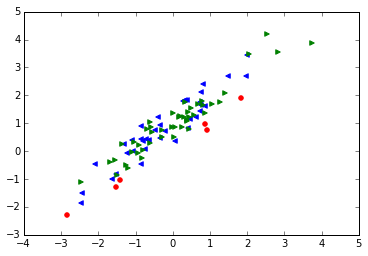

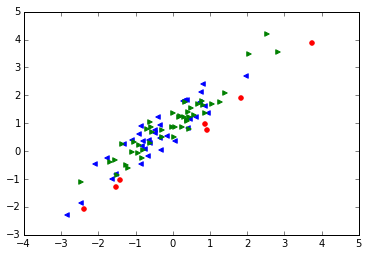

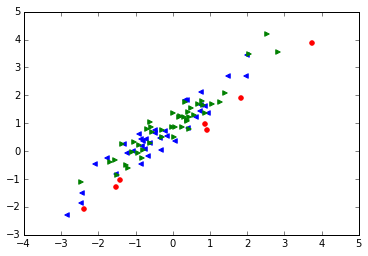

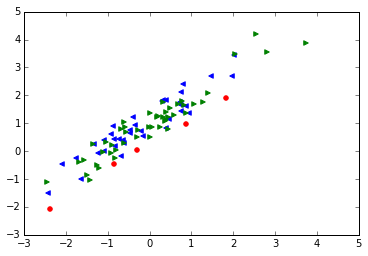

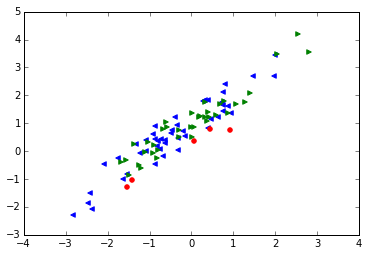

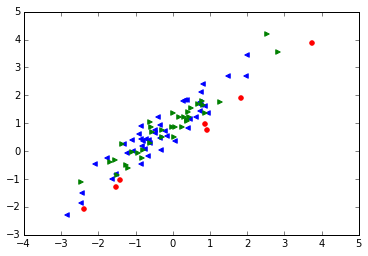

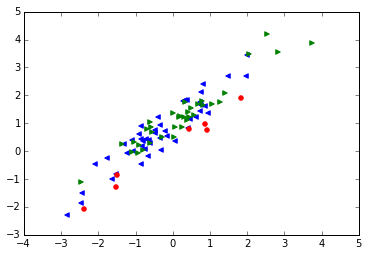

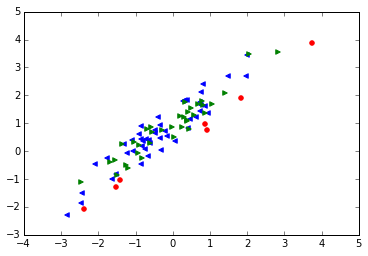

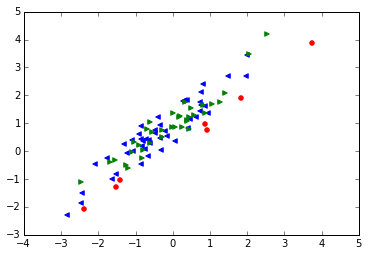

In [61]:
def run(params):
    fileName = params['dataset']
    size = params['examples']
    dataset = getData(fileName, size)
    (m,n) = dataset.shape
    if fileName == 'Linear' or fileName == 'Non-Separable':
        x = dataset[:,:-1]
        y = dataset[:, -1]
        for i in range(m):
            if y[i] == 1:
                    plt.scatter(x[i,0], x[i,1], marker='<', color='b')
            else:
                    plt.scatter(x[i,0], x[i,1], marker='>', color='g')
    
    print dataset.shape
    
    
    labels = np.unique(dataset[:,-1])
    print labels
    k = len(labels)
    CV_idx = KFold(len(dataset), n_folds=10)
    
    svm = SVM(n-1)
    cm = np.zeros((k,k))
    cm_test = np.zeros((k,k))
    for train_idx, test_idx in CV_idx:
        svm.train(dataset[train_idx],  params)
        cm = np.add(cm, svm.test(dataset[test_idx], labels))
        cm_test = np.add(cm_test, validation(dataset[train_idx], dataset[test_idx], labels, params))
        #break
    print "Confusion Matrix"
    print cm
    print "Confusion Matrix(SciKit Library)"
    print cm_test
    
    precision = getPrecision(cm)
    recall = getRecall(cm)
    
    print "Accuracy\t:\t", getAccuracy(cm)
    print "Precision\t:\t", precision[0]
    print "Recall\t\t:\t", recall[0]
    print "F-Measure\t:\t", getFMeasure(precision, recall)[0]
    
if __name__ == '__main__':
    
    params = {
        #'dataset'          : 'Iris', #C=1000, alpha = 1e-4
        #'dataset'          : 'Linear',
        'dataset'          : 'Non-Separable',
        #'dataset'           : 'Bank',
        #'dataset'           : 'Breast-Cancer',
        'examples'        : 100,
        'C'               : 0.1,
        'alpha_threshold' : 1e-4
    }
    run(params)